# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
sc.install_pypi_package("numpy==1.18.1") #Install numpy version 1.18.1
sc.install_pypi_package("pandas") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib") #Install matplotlib from given PyPI repository

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
17,application_1583087787771_0018,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached numpy-1.18.1-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.5
    Not uninstalling numpy at /usr/local/lib64/python3.6/site-packages, outside environment /tmp/1585491841761-0
    Can't uninstall 'numpy'. No files were found to uninstall.

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.6-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (90 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

ERROR: python36-sagemaker-pyspark 1.2.6 requires pyspark==2.3.2, which is not installed.

In [2]:
# import libraries
# Starter code
# from pyspark.ml.linalg import Vectors

from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler



from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import lit


from collections import Counter, defaultdict
import string
from math import log10, floor

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1  
boto                       2.49.0 
cycler                     0.10.0 
jmespath                   0.9.4  
kiwisolver                 1.1.0  
lxml                       4.4.2  
matplotlib                 3.2.1  
mysqlclient                1.4.6  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.18.1 
pandas                     1.0.3  
pip                        20.0.2 
py-dateutil                2.2    
pyparsing                  2.4.6  
python-dateutil            2.8.1  
python36-sagemaker-pyspark 1.2.6  
pytz                       2019.3 
PyYAML                     3.11   
setuptools                 46.1.3 
six                        1.13.0 
soupsieve                  1.9.5  
wheel                      0.34.2 
windmill                   1.6

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)

df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [5]:
df = df.filter(~df.firstName.isNull())
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|4630448|   0|        0|     0|            0|       0|4630448|    0|       0|     0|   0|           0|        0|4630448|     0|  0|        0|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Types of Exploratory Analysis

There are two sorts of aggregations to conducting analysis. One is user-specific data i.e. data pertaining to individual users. This is data like time spent on the app, device used to listen to the song etc.

The other is focusing on the time-specific data i.e. the time-specific happenings like people leaving the app, people joining the app, daily user interaction etc. 

It is intelligent to work from this frame of reference as it helps to factor and refactor the code along these lines.

# Creation of User-specific Database

In [6]:
df.show(n=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|     auth|firstName|gender|itemInSession|lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|           Popol Vuh|Logged In|    Shlok|     M|          278| Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|         Los Bunkers|Logged In|  Vianney|     F|            9|  Miller| 238.39302| paid|San Francisco-Oak...|  

In [7]:
df_churn = (df.select(["registration", "page"])
            .filter(df.page == "Cancellation Confirmation")
            .withColumn('churn', lit(1))
            .select(["registration", "churn"]))

df_users = df.select("registration").distinct()

df_users = (df_users.join(df_churn,
                          df_users.registration==df_churn.registration, 
                          how="left")
            .select(df_users.registration, "churn")
            .na.fill(0))

df_users.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+
| registration|churn|
+-------------+-----+
|1524717768000|    0|
|1526966751000|    1|
|1527561485000|    0|
|1528257541000|    0|
|1529873890000|    0|
+-------------+-----+
only showing top 5 rows

In [8]:
## Add number of individual pages used

def add_all_pages(df, df_users):
    
    page_names = [row.page for row in df.select("page").distinct().collect()]
    
    for page in page_names:
        df_users = add_col_page(df, df_users, page)
        
    return df_users


def add_col_page(df, df_users, page_name):

    df_temp = (df.select(["registration", "page"])
               .filter(df.page==page_name)
               .groupby("registration").count()
               .selectExpr("registration as registration", "count as " + page_name.lower().replace(" ", "_")))

    return (df_users.join(df_temp, df_users.registration==df_temp.registration, how="left")
            .drop(df_temp.registration)
            .na.fill(0))

df_users = add_all_pages(df, df_users)

## Add gender column

df_users = (df.select(["registration", "gender"])
            .drop_duplicates()
            .join(df_users, df_users.registration==df.registration)
            .drop(df_users.registration))

## Add the OS

check_udf = F.udf(lambda x: "Linux" if "Linux" in x 
                  else "Windows" if "Windows" in x
                  else 'Mac OS')

df_temp = df.withColumn('OS', check_udf(F.col('userAgent'))).select(["registration", "OS"]).drop_duplicates()
df_users = df_users.join(df_temp, df_users.registration==df_temp.registration).drop(df_temp.registration)

## Add the iphone data

check_iphone = F.udf(lambda x: 1 if "iPhone" in x else 0)
df_iphone = (df.withColumn("iphone", check_iphone(F.col('userAgent')))
             .select(["registration", "iphone"])
             .drop_duplicates())

df_users = (df_users
 .join(df_iphone, df_users.registration==df_iphone.registration, how="inner")
 .drop(df_users.registration))

## Add the ipad data

check_ipad = F.udf(lambda x: 1 if "iPad" in x else 0)
df_ipad = (df.withColumn("ipad", check_ipad(F.col('userAgent')))
             .select(["registration", "ipad"])
             .drop_duplicates())

df_users = (df_users
 .join(df_ipad, df_users.registration==df_ipad.registration, how="inner")
 .drop(df_users.registration))


## Add minimum and maximum time to find average time spent

df_min = df.select(["registration", "ts"]).groupby("registration").min().drop("min(registration)")
df_max = df.select(["registration", "ts"]).groupby("registration").max().drop("max(registration)")
df_time = df_min.join(df_max, df_min.registration==df_max.registration).drop(df_max.registration)

df_users = df_users.join(df_time, df_users.registration==df_time.registration).drop(df_users.registration)

## Add location data

locations_raw = [row.location for row in (
    df.select(['registration', 'location'])
    .drop_duplicates()
    .select('location')
    .collect()
)]

unique_locations = set([item for sublist in 
                        [row.split()[-1].split("-") 
                         for row in locations_raw] 
                        for item in sublist])

locations_dict = defaultdict(int, Counter([item for sublist 
                                           in [loc.split()[-1].split("-") 
                                               for loc in locations_raw] for item in sublist]))

df_location = df.select(["registration", "location"]).drop_duplicates()

df_users = (df_users
 .join(df_location, df_location.registration==df_users.registration, how="inner")
 .drop(df_users.registration))

for location in unique_locations:
    
    check_udf = F.udf(lambda x: 1 if location in x else 0)
    df_users = df_users.withColumn(location, check_udf(F.col('location')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df_users_pd = df_users.toPandas()
df_users_pd = df_users_pd[["registration"] + [col for col in df_users.columns if col != "registration"]]
df_users_pd.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    registration gender  churn  cancel  submit_downgrade  ...  OR  NE  NJ  MD  NC
0  1524717768000      M      0       0                 0  ...   0   0   0   0   0
1  1526966751000      M      1       1                 0  ...   0   0   0   0   0
2  1527561485000      M      0       0                 0  ...   0   0   0   0   0
3  1528257541000      M      0       0                 0  ...   0   0   0   1   0
4  1529873890000      F      0       0                 0  ...   0   0   1   0   0

[5 rows x 79 columns]

In [10]:
df_users_pd.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['registration', 'gender', 'churn', 'cancel', 'submit_downgrade',
       'thumbs_down', 'home', 'downgrade', 'roll_advert', 'logout',
       'save_settings', 'cancellation_confirmation', 'about', 'settings',
       'add_to_playlist', 'add_friend', 'nextsong', 'thumbs_up', 'help',
       'upgrade', 'error', 'submit_upgrade', 'OS', 'iphone', 'ipad', 'min(ts)',
       'max(ts)', 'location', 'SC', 'GA', 'AL', 'WI', 'KY', 'WY', 'IN', 'VT',
       'ND', 'DC', 'TX', 'MI', 'LA', 'IA', 'HI', 'SD', 'TN', 'NV', 'NM', 'ME',
       'NY', 'PA', 'ID', 'WA', 'MS', 'AR', 'AK', 'WV', 'VA', 'CO', 'MA', 'RI',
       'MN', 'UT', 'AZ', 'IL', 'KS', 'OK', 'MT', 'MO', 'DE', 'CT', 'FL', 'OH',
       'NH', 'CA', 'OR', 'NE', 'NJ', 'MD', 'NC'],
      dtype='object')

In [11]:
## Prepping data for stacked bars

pages = np.array([row.page.lower().replace(" ", "_") for row in df.select("page").drop_duplicates().collect()])

values = np.array([[(df_users_pd[(df_users_pd["churn"]==0)][page].sum()/
                     df_users_pd[(df_users_pd["churn"]==0)].shape[0]),
                    (df_users_pd[(df_users_pd["churn"]==1)][page].sum()/
                     df_users_pd[(df_users_pd["churn"]==1)].shape[0])]
                   for page in pages])

order_values = np.argsort((values[:, 0] - values[:, 1]) / values[:, 1])
pages = list(np.array(pages)[order_values])
values = values[order_values]

avg_pages = (df_users_pd[pages].sum(axis=1)[(df_users_pd["churn"]==0)].sum()
             / df_users_pd[(df_users_pd["churn"]==0)].shape[0],
             df_users_pd[pages].sum(axis=1)[(df_users_pd["churn"]==1)].sum() /
             df_users_pd[(df_users_pd["churn"]==1)].shape[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:


def create_100pc_stacked_bar(values=values, pages=pages, title='Average number of times a user visited each page type'):
    
    
    font = {'size': 18}
    matplotlib.rc('font', **font)
    
    round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1)) 

    bar_pc = (np.array(values) / np.array(values).sum(axis=1).reshape(-1, 1)).T.copy()
    y_pos = np.arange(len(pages))

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    colors ='gr'
    patch_handles = []
    # left alignment of bar_pc starts at zero
    left = np.zeros(len(pages)) 
    for i, d in enumerate(bar_pc):
        patch_handles.append(ax.barh(y_pos, d, 
          color=colors[i%len(colors)], align='center', 
          left=left))
        left += d

    # search all of the bar segments and annotate
    for j in range(len(patch_handles)):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            if values[i, j] != 0:
                ax.text(x,y, str(round_to_n(values[i,j], 2)).rstrip('0').rstrip('.'), ha='center', va='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(pages)
    ax.set_xticks([])

    legend_elements = [Patch(facecolor='g', edgecolor='g', label='Non-churners'),
                       Patch(facecolor='r', edgecolor='r', label='Churners')]

    ax.legend(handles=legend_elements, loc="lower right")
    ax.set_xlabel(title, fontdict={"fontsize": 25})
    
    plt.yticks(rotation=45)
    plt.show()
    
    matplotlib.rcdefaults()
    return

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

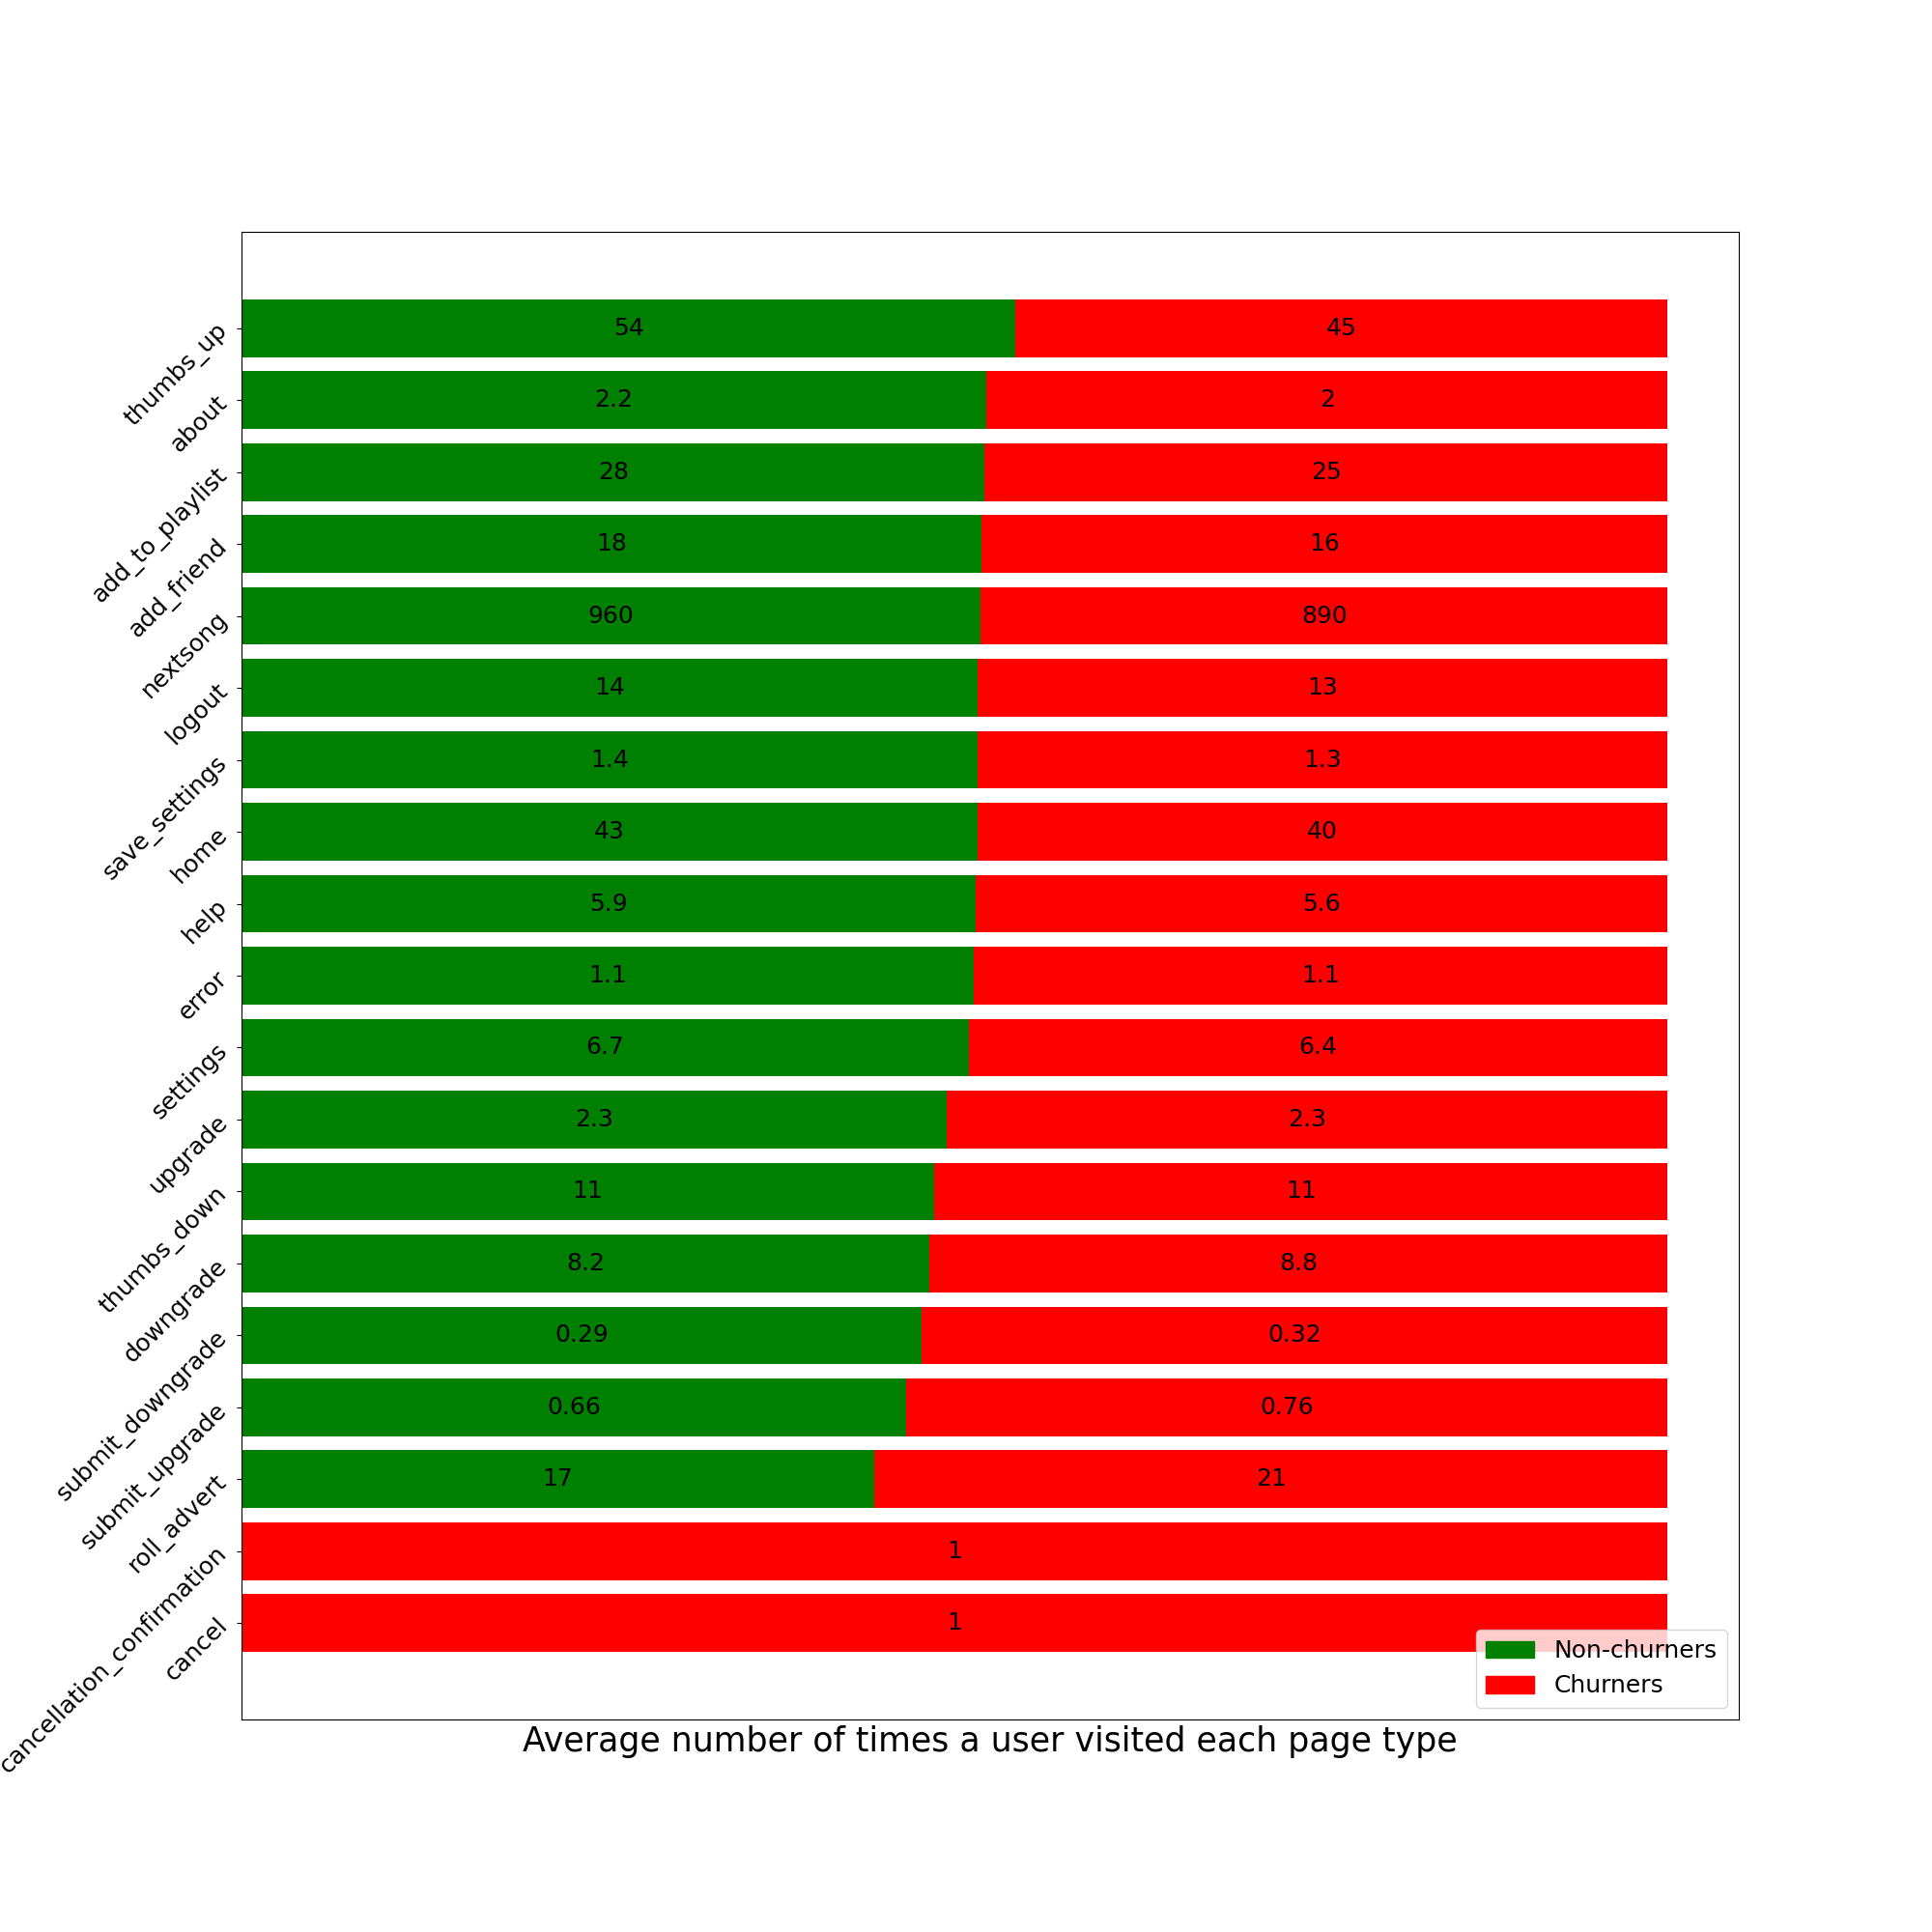

In [61]:
create_100pc_stacked_bar()

%matplot plt

In [62]:
df_users_pd["time_difference_days"] = ((df_users_pd["max(ts)"] - df_users_pd["min(ts)"]) / 1000 / 86400)

mean_time = [df_users_pd[df_users_pd["churn"]==0]["time_difference_days"].mean(),
             df_users_pd[df_users_pd["churn"]==1]["time_difference_days"].mean()]



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

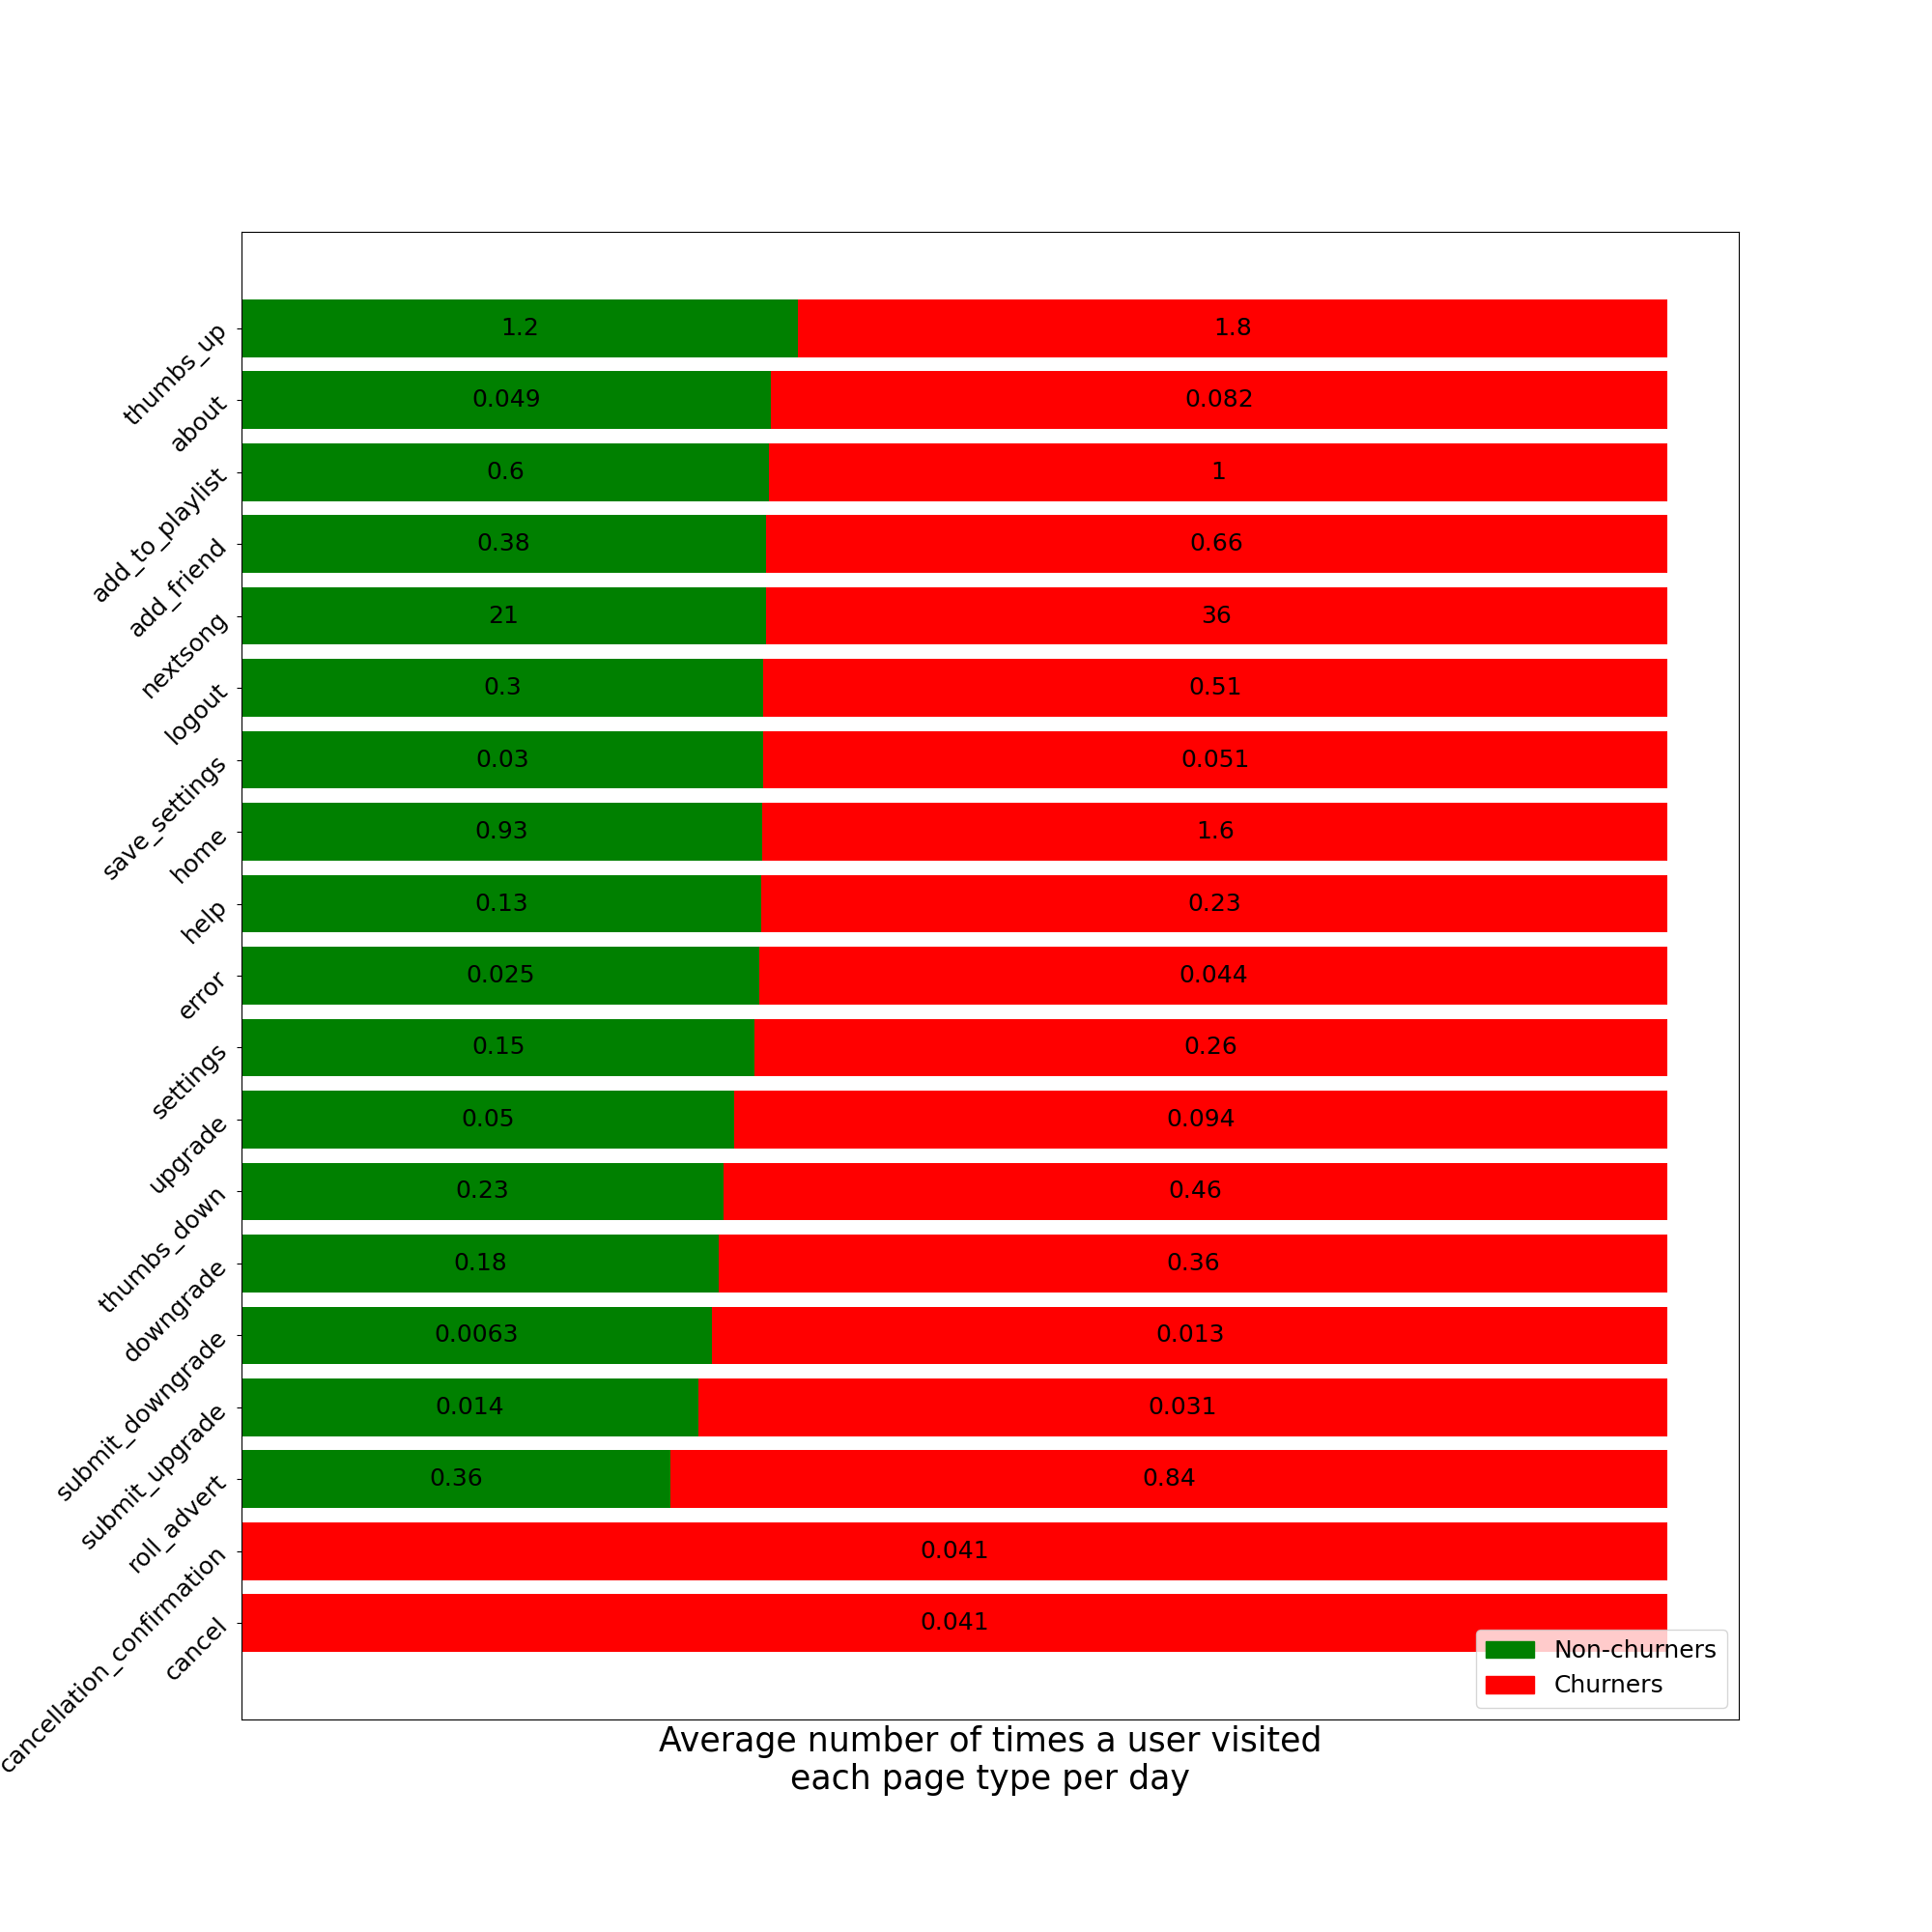

In [63]:


create_100pc_stacked_bar(values / np.array(mean_time), pages, """Average number of times a user visited
each page type per day""")

%matplot plt

In [64]:
stay_time_spent = df_users_pd[df_users_pd["churn"]==0]["time_difference_days"]
left_time_spent = df_users_pd[df_users_pd["churn"]==1]["time_difference_days"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

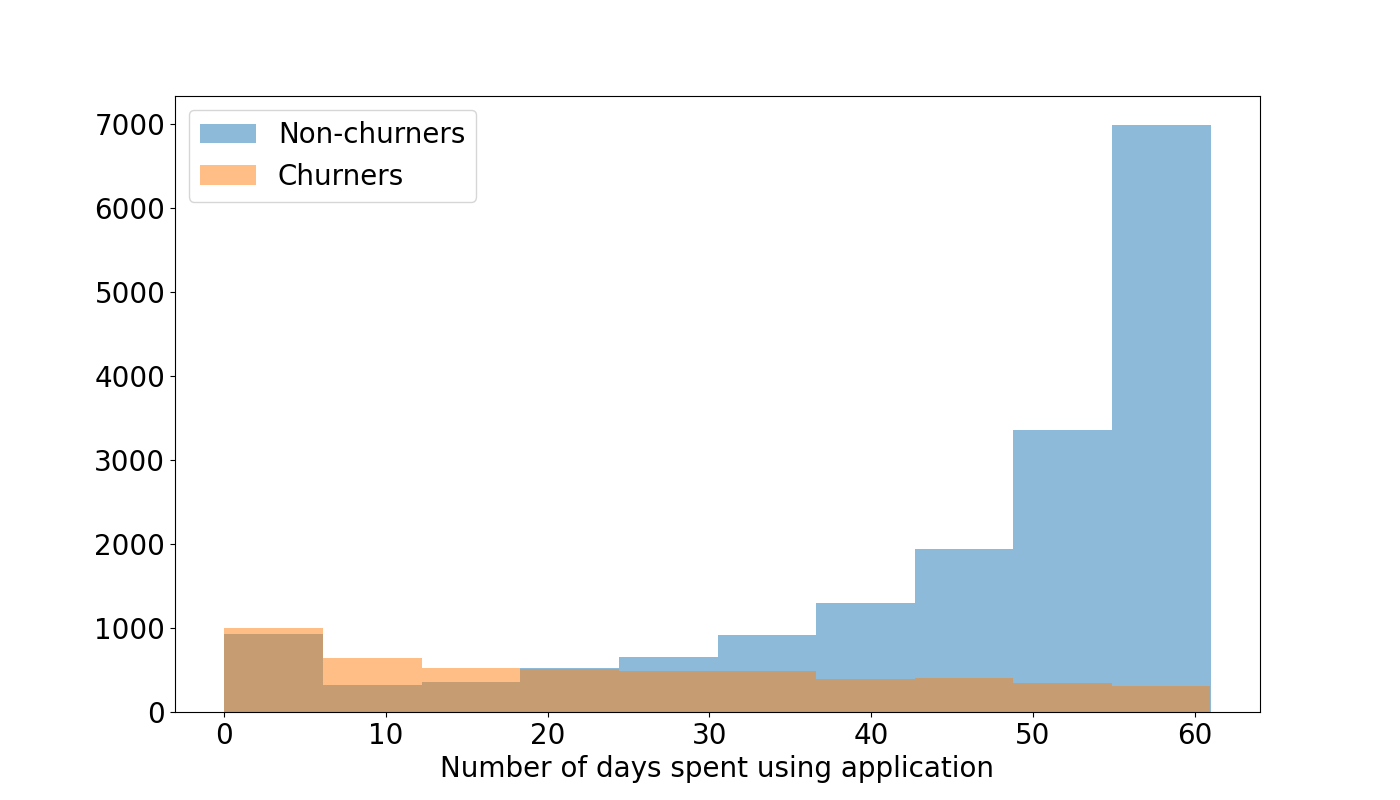

In [80]:
# %%local
# %matplotlib inline

plt.clf()

font = {'size': 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# matplotlib.rcdefaults();
plt.hist(stay_time_spent, alpha=0.5, label='Non-churners')
plt.hist(left_time_spent, alpha=0.5, label='Churners')
plt.legend(loc='best', prop={'size': 20})
plt.xlabel("Number of days spent using application")
plt.show()

%matplot plt

# Churn Rates

In [39]:
# df_users_pd.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
def churn_bar_plot(title, col="gender", df=df_users_pd):
    matplotlib.rcdefaults()
    df_users_pd[[col, "churn"]].groupby(col).mean().sort_values("churn", ascending=False).plot.bar(legend=None)
    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel("")
    plt.show()
    


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

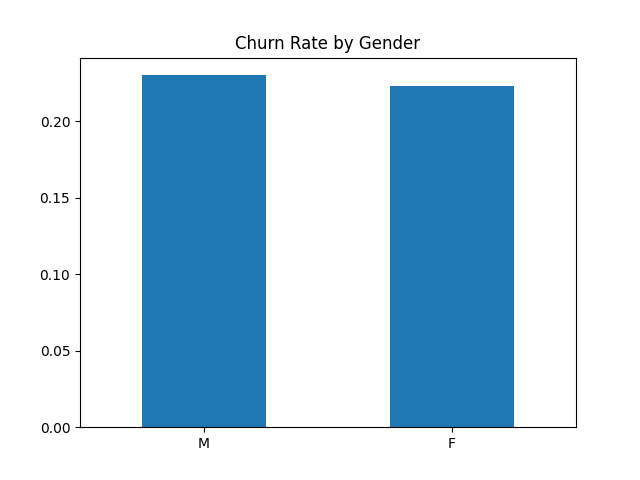

In [86]:


churn_bar_plot("Churn Rate by Gender", "gender")

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

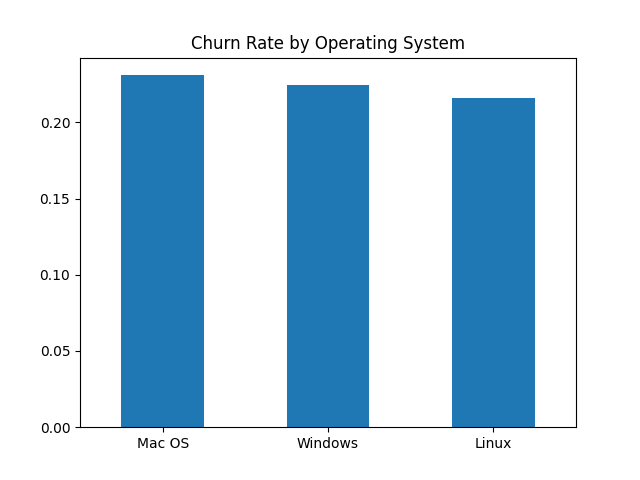

In [87]:
churn_bar_plot("Churn Rate by Operating System", "OS")

%matplot plt

In [89]:
def churn_rates(cols, df=df_users_pd, title='Churn rate by states'):
    
    font = {'size': 25}
    matplotlib.rc('font', **font)
    
    fig, ax = plt.subplots(figsize=(42, 30))
    df[cols] = df[cols].astype(int)
    rates = [df[df[col]==1]["churn"].mean() for col in cols]
    pd.DataFrame([rates], columns=cols).T.sort_values(0, ascending=False).plot.bar(ax=ax)
    ax.get_legend().remove()
    plt.xticks(rotation=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

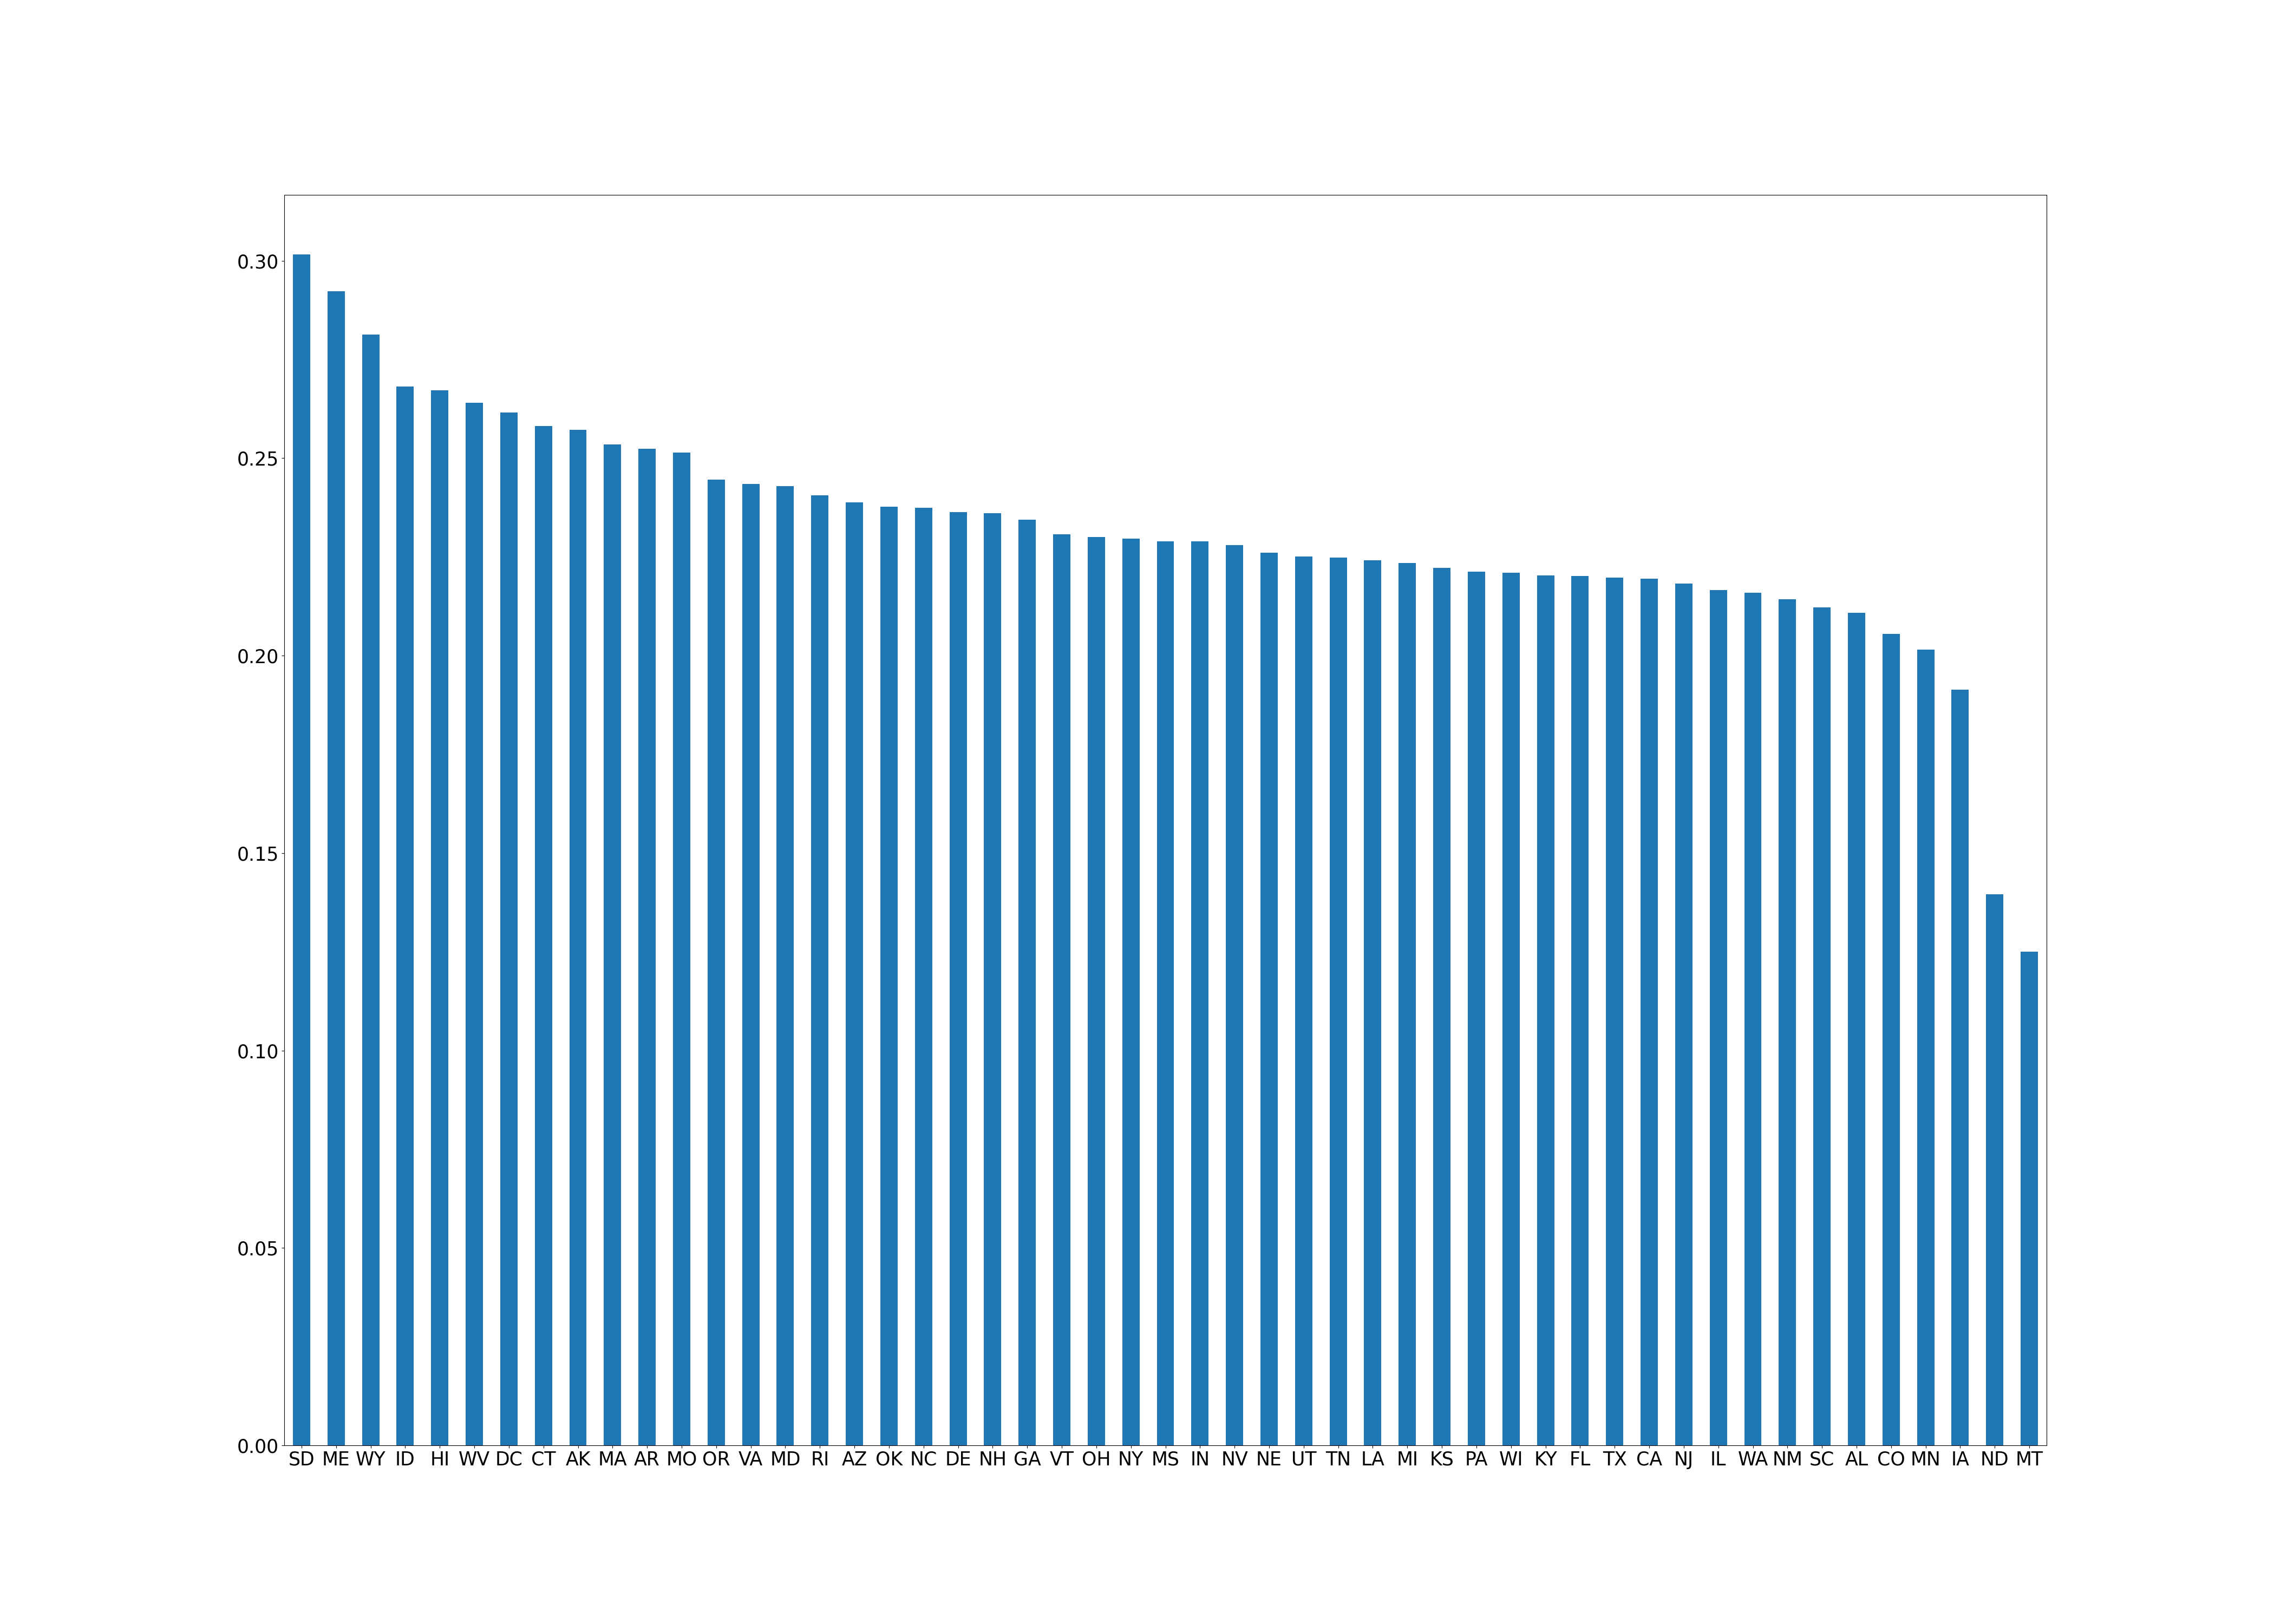

In [90]:
churn_rates(list(unique_locations))

%matplot plt

# Most heard artists and songs

In [91]:
(df.select("artist")
 .groupby("artist")
 .count()
 .sort(col('count').desc())
 .head(11))[1:]



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist='Kings Of Leon', count=169824), Row(artist='Coldplay', count=164369), Row(artist='Florence + The Machine', count=115348), Row(artist='Dwight Yoakam', count=107284), Row(artist='Muse', count=104710), Row(artist='BjÃ\x83Â¶rk', count=104654), Row(artist='The Black Keys', count=102694), Row(artist='Justin Bieber', count=100219), Row(artist='Jack Johnson', count=94263), Row(artist='Eminem', count=84548)]

In [101]:
def add_relevant_newline(song_l, space_skip=16):

#     song_l = 'Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)'

    space_indices = [k for k, v in 
                     enumerate(song_l) 
                     if v == ' ']

    imp_space_indices = []
    num = 1

    for v in space_indices:
        if v > num * space_skip:
            imp_space_indices.append(v)
            num += 1

    for index in imp_space_indices:
        song_l = song_l[:index] + "\n" + song_l[index + 1:]

    return song_l


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
def top_songs_artists(cols="artist"):
    font = {'size': 15}
    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(20, 20))
      
    data = [[row[cols], row['count']] for row in
              (df.select(cols)
               .groupby(cols)
               .count()
               .sort(col('count').desc())
               .head(11))][1:]
    
    data = [[add_relevant_newline(a[0]), a[1]] for a in data]
    
    df_temp = pd.DataFrame(data).set_index(0).sort_values(1, ascending=False)
    
    
    
    df_temp.plot.bar(ax=ax)


    ax.get_legend().remove()
    plt.title("")
    plt.xlabel("", fontsize=40)
    matplotlib.rcdefaults()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

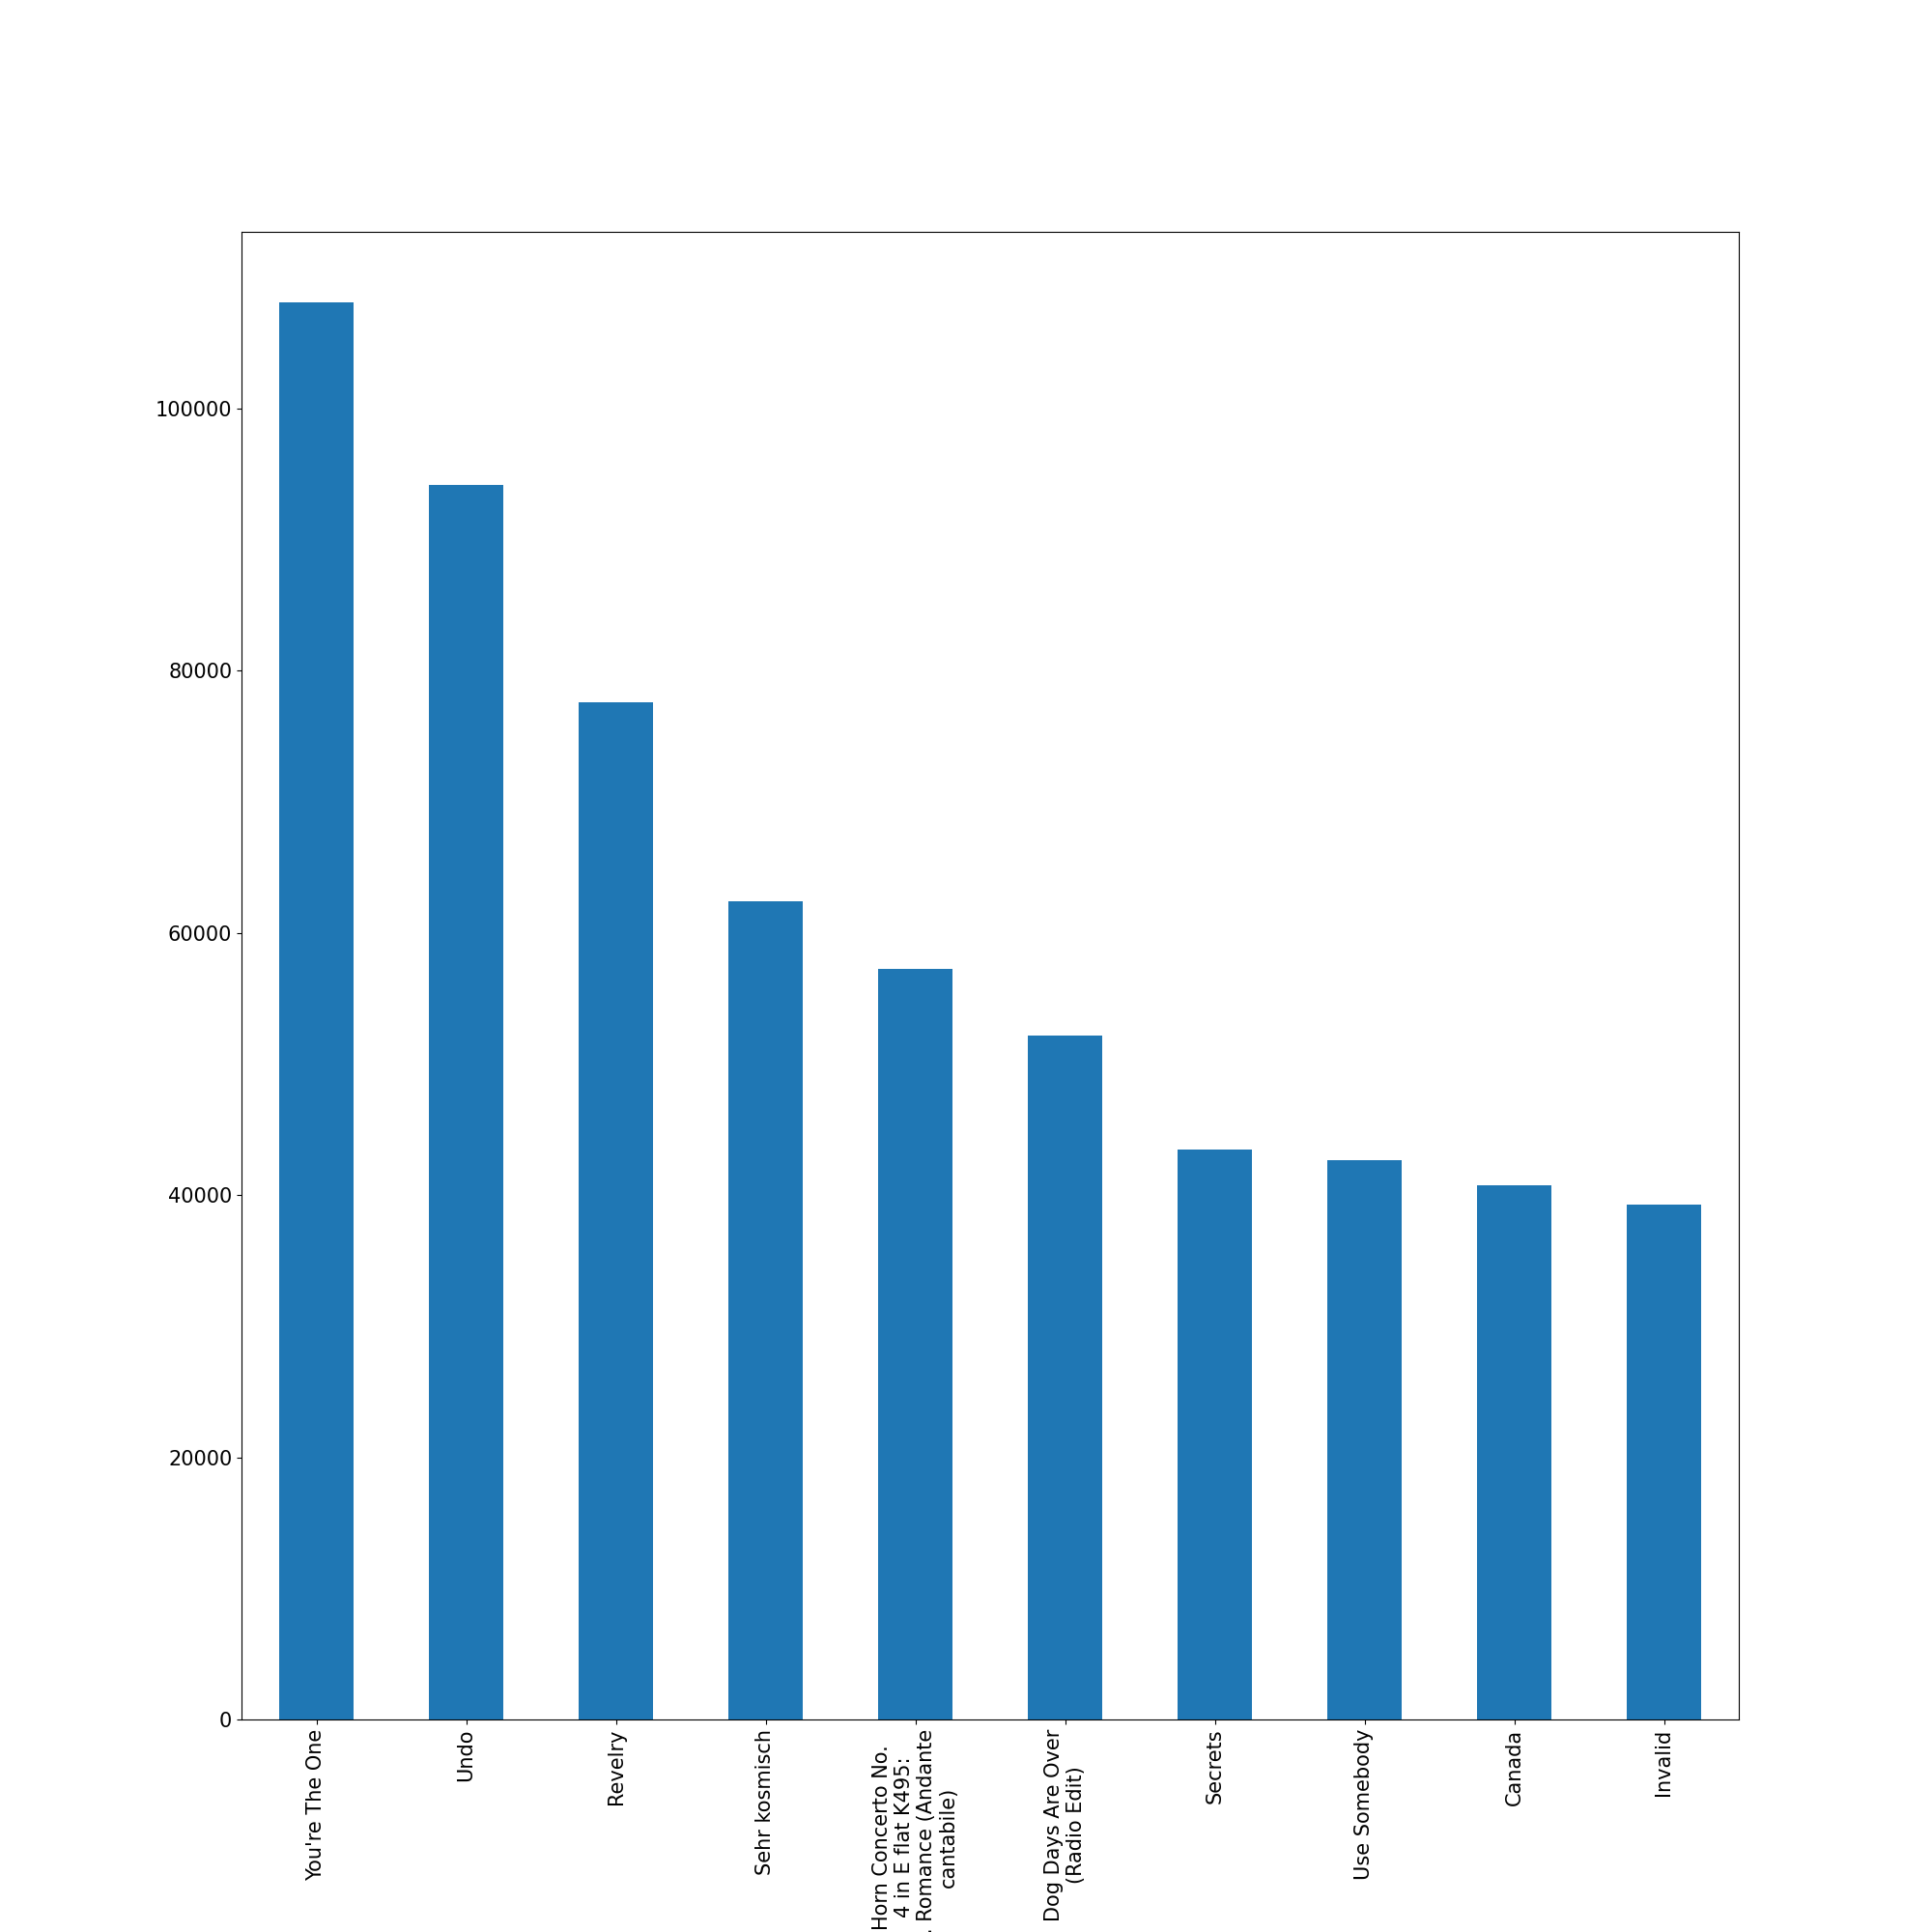

In [103]:
top_songs_artists("song")

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

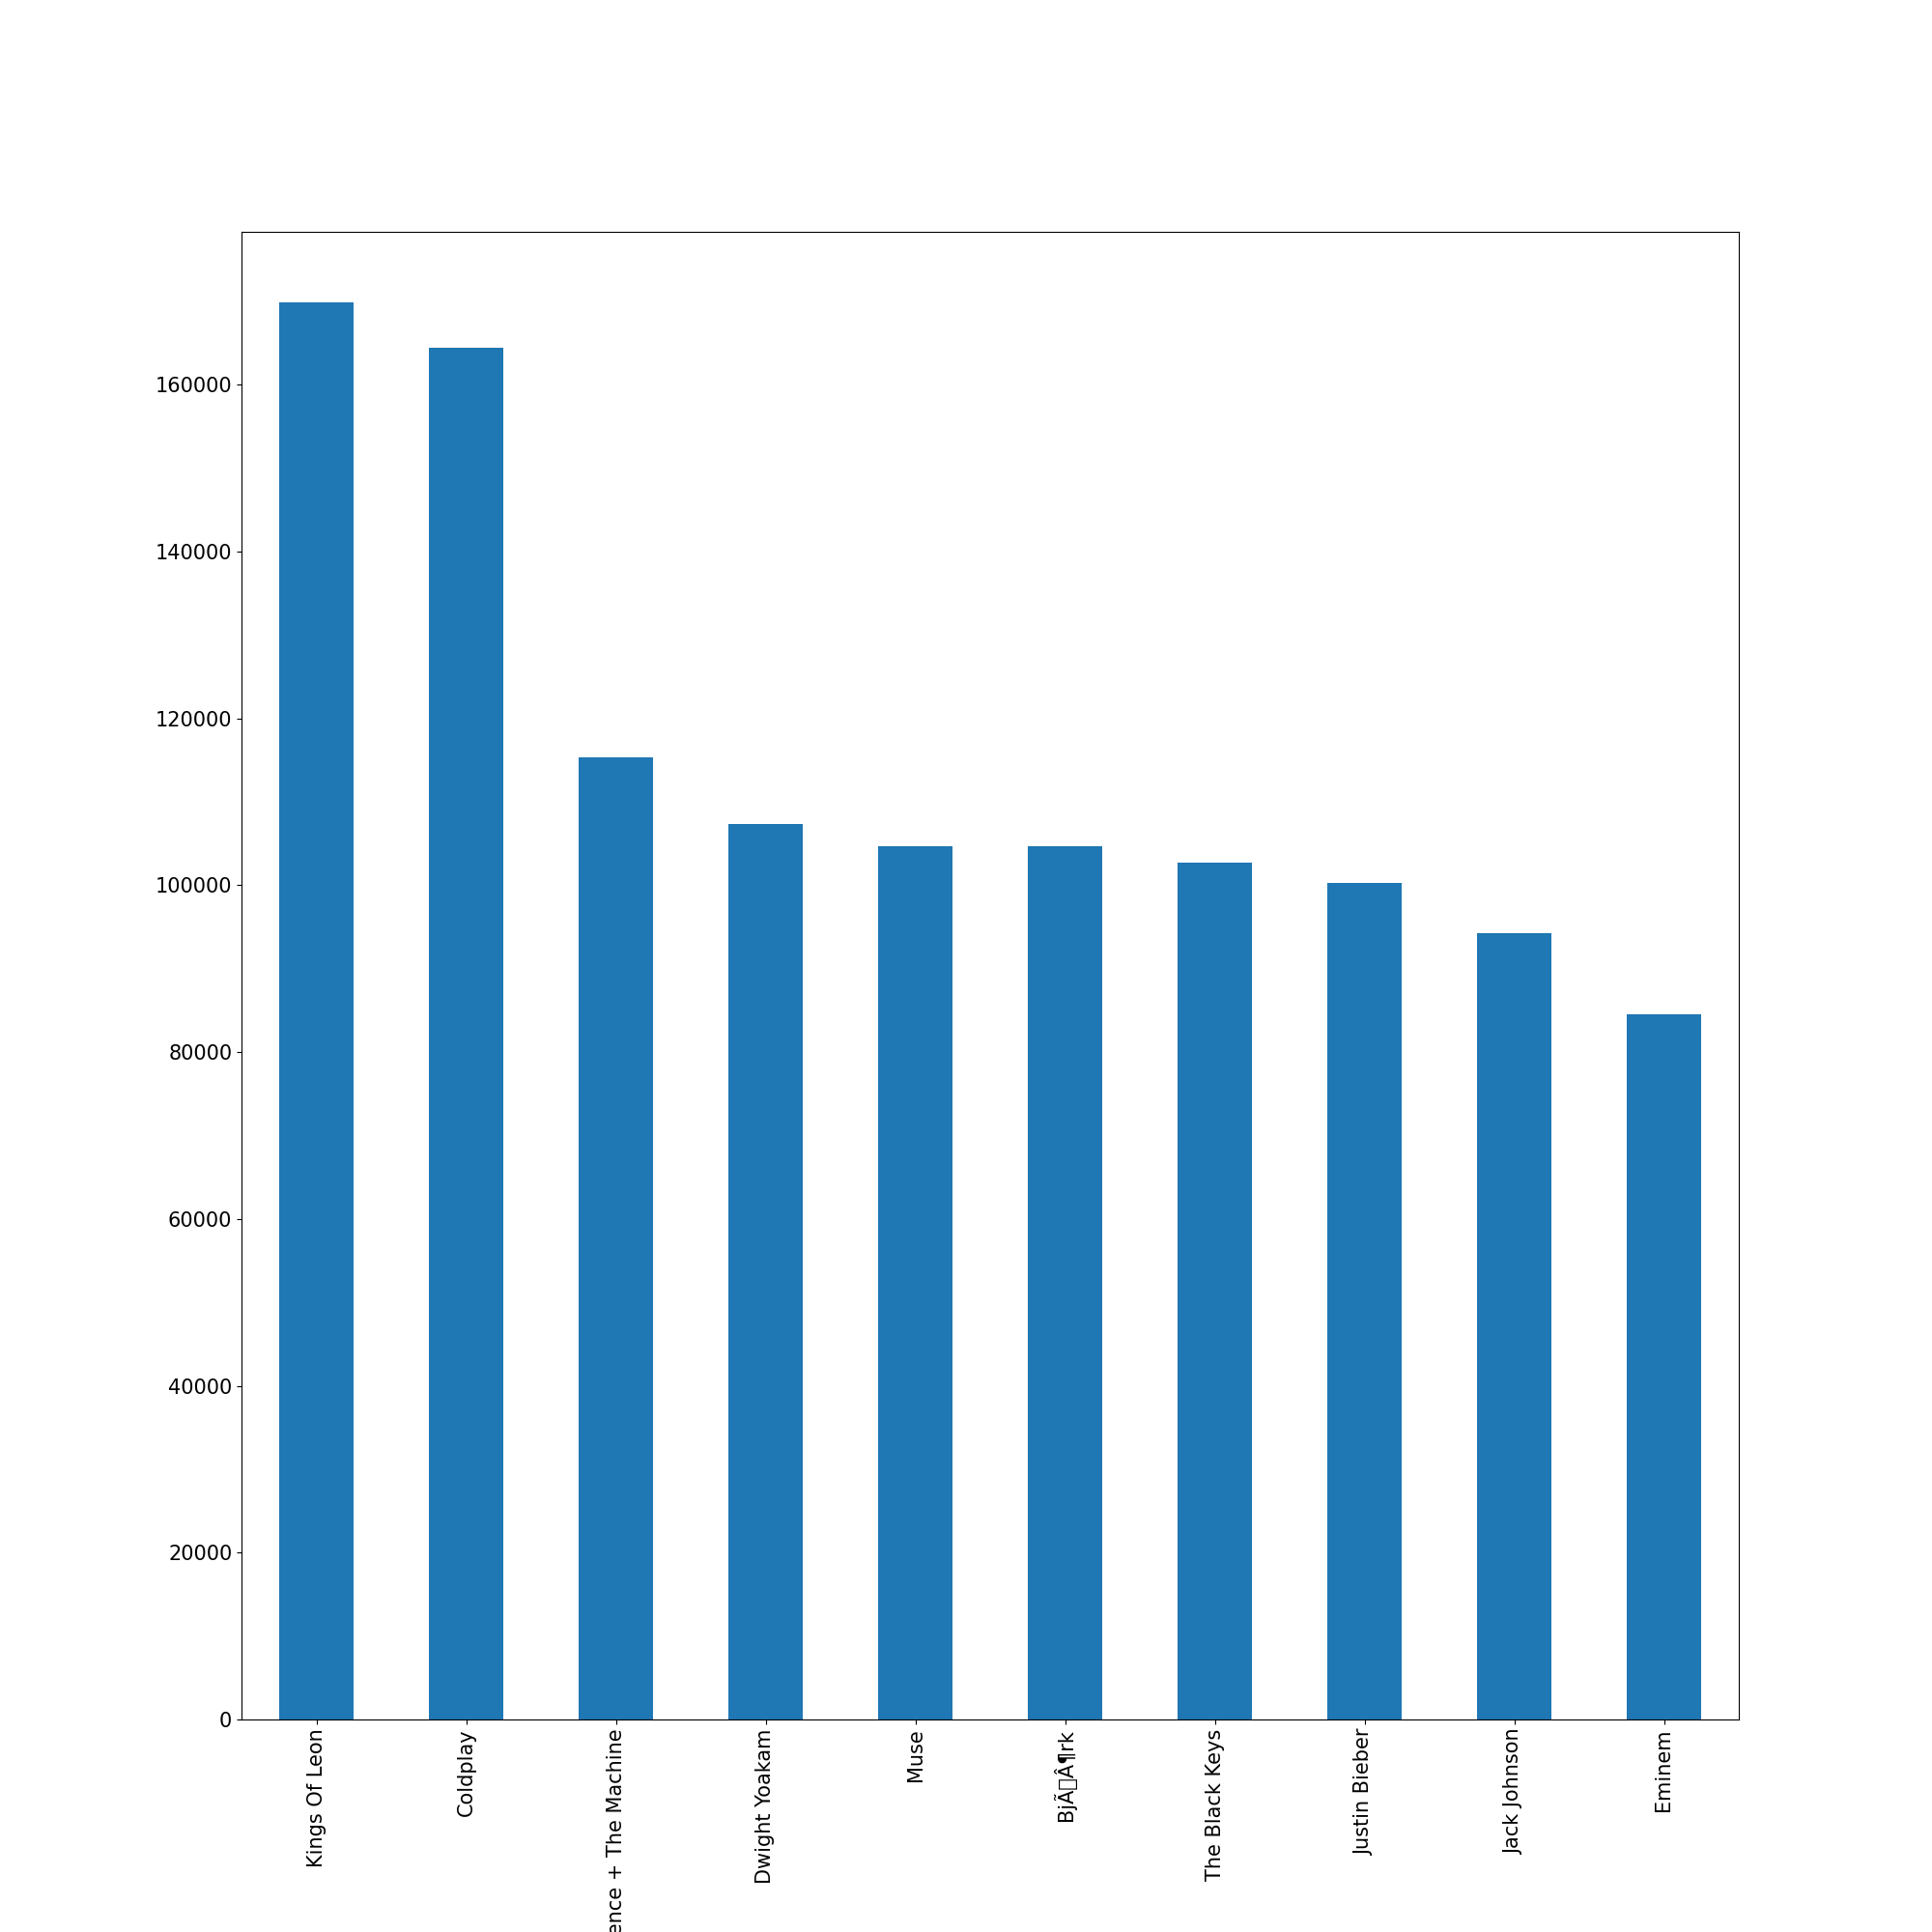

In [104]:
top_songs_artists()

%matplot plt

# Datetime database

In [105]:
df = (df.withColumn('date', (df['ts'] / 1000.0)
                    .cast('Timestamp')
                    .cast('Date')))

df_dates = (df.select(['registration', 'date'])
            .groupby('date')
            .agg(F.countDistinct('registration').alias('daily_avg_users'))
            .sort(col('date')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
df_dates = (df_dates.join((df.select(['registration', 'date', 'page'])
                          .filter(df.page == 'Cancellation Confirmation')
                          .groupby('date')
                          .agg(F.countDistinct('registration').alias('daily_churners'))
                          .sort(col('date'))), on= df.date==df_dates.date)
            .drop(df_dates.date))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
df_temp = (df.select(['ts', 'date', 'registration'])
           .groupby('registration').min('ts').select(col('registration'), col('min(ts)').alias('ts')))

df_temp = df_temp.join(df.select(['registration', 'ts','date', 'page']), on=['registration', 'ts'])

df_temp = (df_temp#.filter(df_temp.page=='Home')
           .groupby("date")
           .agg(F.countDistinct('registration')
                .alias('new_users_entering'))
           .sort(col('date')))

df_dates = df_dates.join(df_temp, "date").sort(col('date'))

df_dates = df_dates.withColumn('net_users_added', col('new_users_entering') - col('daily_churners'))

windowval = (Window.orderBy('date')
             .rangeBetween(Window.unboundedPreceding, 0))

df_dates = df_dates.withColumn('total_users_app', F.sum('net_users_added').over(windowval))
df_dates.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+--------------+------------------+---------------+---------------+
|      date|daily_avg_users|daily_churners|new_users_entering|net_users_added|total_users_app|
+----------+---------------+--------------+------------------+---------------+---------------+
|2018-10-01|           6117|           117|              6117|           6000|           6000|
|2018-10-02|           6466|           129|              3395|           3266|           9266|
|2018-10-03|           6250|           129|              2247|           2118|          11384|
|2018-10-04|           6339|           126|              1624|           1498|          12882|
|2018-10-05|           6182|           115|              1266|           1151|          14033|
|2018-10-06|           3972|            56|               509|            453|          14486|
|2018-10-07|           3805|            56|               526|            470|          14956|
|2018-10-08|           5873|           108|       

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

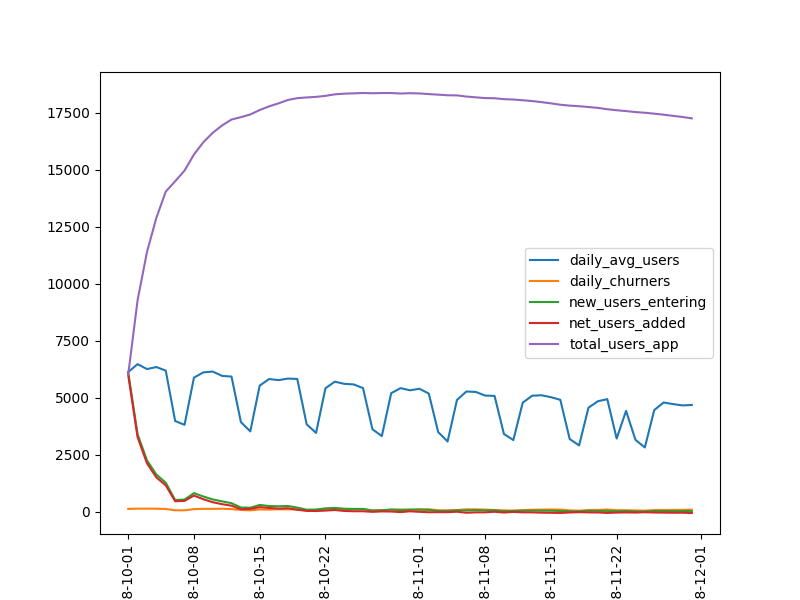

In [108]:
# %%local
# %matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))
df_dates.toPandas().set_index('date').plot(ax=ax)
plt.xticks(rotation=90)

%matplot plt

In [ ]:
# df_users.head()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [109]:
df_users = df_users.withColumn('days_with_app', F.col('max(ts)') - F.col('min(ts)') / 1000 / 86400)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [1]:
# print(df_users.columns)

In [2]:
def get_dummies_pyspark(columns=["gender", "OS"], df=df_users, drop_extra=True):
    
    for column in columns:

        if drop_extra == True:
            types = df.select(column).distinct().rdd.flatMap(lambda x: x).collect()[1:]

        else:
            types = df.select(column).distinct().rdd.flatMap(lambda x: x).collect()[0:]

        types_expr = [(F.when(F.col(column) == ty, 1)
                       .otherwise(0)
                       .alias(column + "_" + ty)) for ty in types]

        df = df.select(*list(df.columns), *types_expr)
    
    return df


df_users = get_dummies_pyspark()

for loc in unique_locations:
    df_users = df_users.withColumn(loc, df_users[loc].cast('int'))
    
df_users = df_users.withColumn("iphone", df_users["iphone"].cast('int'))
df_users = df_users.withColumn("ipad", df_users["ipad"].cast('int'))

df_users = df_users.drop("gender", "OS", "registration", "location", "cancel",
                            "cancellation_confirmation", "max(ts)")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [3]:
assembler = VectorAssembler(inputCols=[a for a in list(df_users.columns) if a != "churn"], outputCol="features")
df_users = assembler.transform(df_users)



In [4]:
data = df_users.select(col("churn").alias("label"), col("features").alias("features_raw"))
data.head()

In [5]:
train, test = data.randomSplit([0.9, 0.1], seed=12345)

In [9]:
## Use randomsearch instead of gridsearch

In [6]:
lr = LogisticRegression() # solver="l-bfgs" here
scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")


modelEvaluator=BinaryClassificationEvaluator()
pipeline = Pipeline(stages=[scaler, lr])

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])
             .addGrid(lr.elasticNetParam, [0, 1])
             .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=5)

cvModel = crossval.fit(train)

In [7]:
trainingSummary = cvModel.bestModel.stages[-1].summary
trainingSummary.totalIterations, trainingSummary.objectiveHistory 

In [8]:
modelEvaluator.evaluate(cvModel.transform(test))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.